In [1]:
import json
import os
from sympy import symbols, simplify, sin, expand
#from pysr import PySRRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.special import jn

/home/paolo/.conda/envs/pymc_env/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
#import sissopp
#from sissopp.py_interface import get_fs_solver

In [2]:
import pymc as pm
import arviz as az

In [3]:
x = np.linspace(-2, 2, 500)
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
noise = rng.normal(size=x.shape)
y = jn(0,x) + noise 

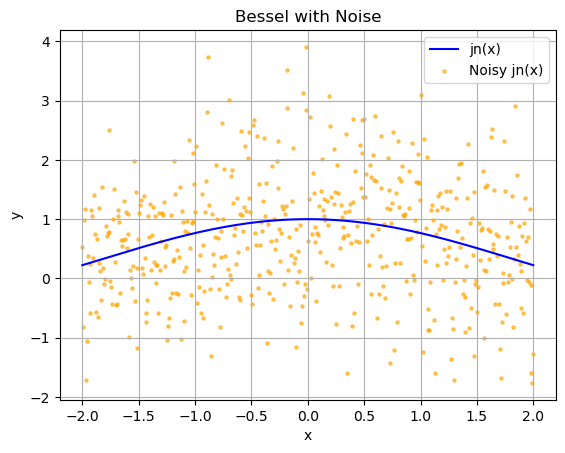

In [4]:
plt.plot(x, jn(0,x), label='jn(x)', color='blue')
plt.scatter(x, y, s=5, alpha=0.6, label='Noisy jn(x)', color='orange')
plt.legend()
plt.title('Bessel with Noise')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [61]:
# Save to CSV in a format SISSO++ expects
df = pd.DataFrame({"sample_id": [f"s{i+1}" for i in range(len(x))], 'f1': x, 'target': y})
df.to_csv("/home/paolo/Thesis/Test_uncertainty/data/bessel_data.csv", index=False)
data_file = "/home/paolo/Thesis/Test_uncertainty/data/bessel_data.csv"

os.environ["SISSOPP_TUT_DAT_FILE"] = data_file

In [8]:
# Try the fit with the exact functional form
bessel_json = {
    'data_file': data_file,
     'property_key': 'target',
     'desc_dim': 1,
     'n_sis_select': 10,
     'max_rung': 2,
     'calc_type': 'regression',
     'min_abs_feat_val': 1e-05,
     'max_abs_feat_val': 1e8,
     'n_residual': 10,
     'n_models_store': 10,
     'leave_out_frac': 0.0,
     'leave_out_inds': [],
     'opset': ['add', 'sub', 'mult', 'div', 'cos', 'sin', 'sqrt', 'sq']
}
json.dump(bessel_json, open("/home/paolo/Thesis/Test_uncertainty/data/bessel.json", "w"), indent=4)

In [ ]:
# # Try the fit with the exact functional form
# bessel_json = {
#     'data_file': data_file,
#      'property_key': 'target',
#      'desc_dim': 1,
#      'n_sis_select': 10,
#      'max_rung': 2,
#      'calc_type': 'regression',
#      'min_abs_feat_val': 1e-05,
#      'max_abs_feat_val': 1e8,
#      'n_residual': 10,
#      'n_models_store': 10,
#      'leave_out_frac': 0.0,
#      'leave_out_inds': [],
#      'opset': ['add', 'sub', 'mult', 'div', 'cos', 'sin', 'sqrt', 'sq']
# }
# json.dump(bessel_json, open("/home/paolo/Thesis/Test_uncertainty/data/bessel.json", "w"), indent=4)

In [5]:
# Extract the formulas and the values of the parameters from the SISSO output
formulas = []
a0_list = []
c0_list = []
for i in range(10):
    filename = f'./models_bessel/train_dim_1_model_{i}.dat'
    with open(filename, 'r') as f:
        line1 = next(f)               # First line
        for _ in range(4): next(f)    # Skip lines 2 to 5
        line6 = next(f)               # Sixth line
        formula = line1.replace('#', '').strip()
        # Split line6 by spaces
        parts = line6.strip().split()
        a0_i = parts[3].rstrip(',')
        c0_i = parts[4].rstrip(',')

        formulas.append(formula)
        a0_list.append(a0_i)
        c0_list.append(c0_i)
        print(formula, a0_i, c0_i)

c0 + a0 * cos(f1) 5.658606708118499e-01 4.424985131794483e-01
c0 + a0 * (sin(f1) * f1) -3.973674237902985e-01 1.045558581613912e+00
c0 + a0 * (sin(f1) / f1) 1.499892532213888e+00 -5.041481576599264e-01
c0 + a0 * (cos(f1) - (f1^2)) 1.529677668399201e-01 8.342741324225450e-01
c0 + a0 * (f1^2) -2.091164828217434e-01 9.787189664306177e-01
c0 + a0 * (cos(f1) + (f1^2)) -3.288223088712524e-01 1.287891611728266e+00
c0 + a0 * cos((f1^2)) 3.125226008414987e-01 6.272211441695094e-01
c0 + a0 * (cos(f1)^2) 6.502974387726433e-01 4.354497986032717e-01
c0 + a0 * ((f1^2)^2) -5.332333316337674e-02 8.707837692016491e-01
c0 + a0 * (sin(f1) - (f1^2)) 1.557767690331692e-01 9.073142994751718e-01


In [6]:
# Store the numerical values of the parameters into np arrays
a0 = np.array(a0_list, dtype=float)
c0 = np.array(c0_list, dtype=float)
a0, c0

(array([ 0.56586067, -0.39736742,  1.49989253,  0.15296777, -0.20911648,
        -0.32882231,  0.3125226 ,  0.65029744, -0.05332333,  0.15577677]),
 array([ 0.44249851,  1.04555858, -0.50414816,  0.83427413,  0.97871897,
         1.28789161,  0.62722114,  0.4354498 ,  0.87078377,  0.9073143 ]))

In [7]:
a0_simb, c0_simb, x_simb = sp.symbols('a0 c0 f1')
symbol_map = {'x': x_simb, 'a0': a0_simb, 'c0': c0_simb}

# Converts the equtions (stored into the 'Feature Expression' column of df) from strings into sympy objects
sympy_exprs = [sp.sympify(f, locals=symbol_map) for f in formulas]
# Builds Python functions starting from the sympy expressions pruning the constants
functions = [sp.lambdify((x_simb), (expr - c0_simb)/a0_simb, modules='numpy') for expr in sympy_exprs]

In [8]:
sympy_exprs

[a0*cos(f1) + c0,
 a0*f1*sin(f1) + c0,
 a0*sin(f1)/f1 + c0,
 a0*(-f1**2 + cos(f1)) + c0,
 a0*f1**2 + c0,
 a0*(f1**2 + cos(f1)) + c0,
 a0*cos(f1**2) + c0,
 a0*cos(f1)**2 + c0,
 a0*f1**4 + c0,
 a0*(-f1**2 + sin(f1)) + c0]

In [9]:
for expr in sympy_exprs:
    print(sp.simplify((expr - c0_simb)/a0_simb))

cos(f1)
f1*sin(f1)
sin(f1)/f1
-f1**2 + cos(f1)
f1**2
f1**2 + cos(f1)
cos(f1**2)
cos(f1)**2
f1**4
-f1**2 + sin(f1)


In [10]:
# In each column are stacked data for each of the 10 different formulas
Phi = np.column_stack([f(x) for f in functions])
n_features = Phi[:,0].shape
n_features

(500,)

In [12]:
traces = []
for i in range(10):
    with pm.Model() as model:
        # Select the i-th column
        f = Phi[:, i]

        # Priors, Che valori di sigma potrei usare? 10 forse è un po' troppo
        c = pm.Normal("c0", mu=c0[i], sigma=10)
        a = pm.Normal("a0", mu=a0[i], sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=1)

        # Linear model
        mu = c + a * f

        # Likelihood
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from posterior
        trace = pm.smc.sample_smc()
        #trace = pm.sample()
        traces.append(trace)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

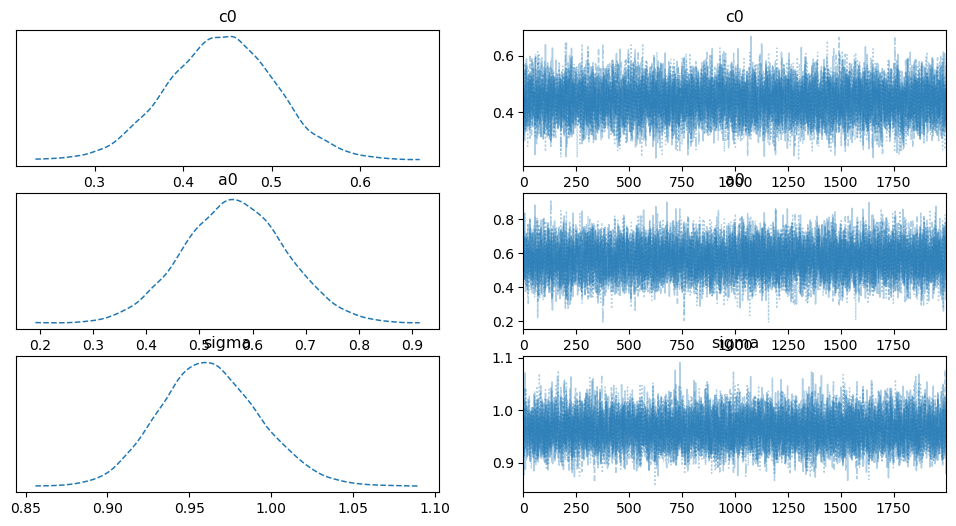

In [13]:
az.plot_trace(traces[0], combined=True);

In [14]:
az.summary(traces[0], round_to=1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.4,0.1,0.3,0.6,0.0,0.0,11902.0,11474.0,1.0
a0,0.6,0.1,0.4,0.7,0.0,0.0,12050.3,11613.5,1.0
sigma,1.0,0.0,0.9,1.0,0.0,0.0,11871.4,11889.5,1.0


In [57]:
# Predictive data
# defines a test set, including points which lie outside the training set, and evaluate Phi at these points
x_test = np.linspace(-3, 3, 600)
Phi_test = np.column_stack([f(x_test) for f in functions])

# Get posterior samples of weights and sigma 
posterior_a0 = traces[0].posterior["a0"].stack(draws=("chain", "draw")).values  # (n_features, n_draws), 2000 draws for each of the 6 chains stacked together
posterior_c0 = traces[0].posterior["c0"].stack(draws=("chain", "draw")).values  # (n_features, n_draws), 2000 draws for each of the 6 chains stacked together
posterior_sigma = traces[0].posterior["sigma"].stack(draws=("chain", "draw")).values  # (n_draws,)

# Compute predictions
y_preds = posterior_c0.mean() + posterior_a0.mean() * Phi_test[:, 0]
y_std = y_preds.std()

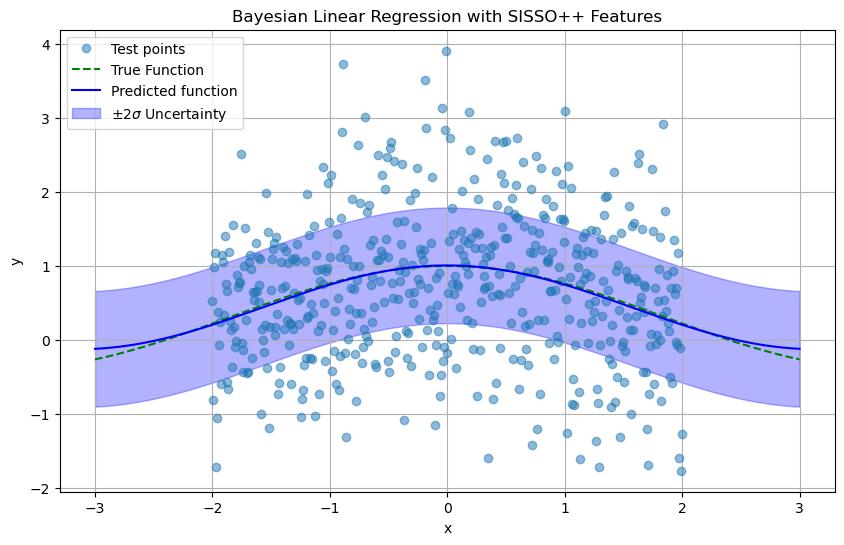

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Test points", alpha=0.5)
plt.plot(x_test, jn(0,x_test), label="True Function", color="green", linestyle="--")
plt.plot(x_test, y_preds, label="Predicted function", color="blue")
# 95% credibility interval standing in between y_mean - 2*std and y_mean + 2*std
plt.fill_between(x_test, y_preds - 2*y_std, y_preds + 2*y_std, alpha=0.3, color="blue", label=r"±2$\sigma$ Uncertainty")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Bayesian Linear Regression with SISSO++ Features")
plt.grid(True)
plt.show()